# Entrega 5.1 - Clasificador (Regresión Logística)

### Grupo 07:
     - Renzo Gambone C.I. 5.155.486-4
     - Germán Ouviña C.I. 4.823.566-1
     - Leandro Rodríguez C.I 4.691.736-4


## 1. Introducción
***
En este informe se presenta lo pedido en la letra del ejercicio 4 del práctico 6. Las partes requeridas se distribuyen en las siguientes secciones:
- En la sección 2 se resuelve lo requerido en la parte **a**, se filtran los candidatos con más de mil votantes.

- La sección 3 muestra cómo separamos el corpus de datos en corpus de entrenamiento y corpus de evaluación (requerido en parte **b**). 

- En la sección 4 (requerido en parte **c**) se genera el modelo de regresión logística para candidatos y partidos, y se selecciona los dos mejores modelos (para candidatos y partidos).

- Luego en la sección 5 (correspondiente a la parte **d**) se toman los dos modelos seleccionados anteriormente y se busca obtener el número de componentes principales que de mejores resultados realizando validación cruzada sobre el corpus de entrenamiento separado anteriormente. 

- En la sección 6 (correspondiente a la parte **e**) se reportan para los 4 modelos resultantes de las partes **c** y **d**. 

- Por último en la sección 7 (parte **f**) usamos el modelo de candidatos obtenido en la parte **d**, mapeamos el resultado al partido que pertenece el candidato y mediante las métricas se realiza una comparación con los resultados anteriores del clasificador de partidos. En esta sección también se realiza la reducción a componentes principales de la parte **d** (sección 5) y se comparan los resultados obtenidos.
 

## 2. Reducción y evaluación del corpus (parte a)
***
En esta sección vamos a filtrar el conjunto de datos para obtener solo los candidatos con más de mil votantes y luego los partidos con más de mil votantes. Esto resulta en dos conjuntos distintos ya que por ejemplo en el partido colorado y en el partido nacional tenemos candidatos que no tienen más de mil votantes, por lo tantos esos ejemplos no son considerados en el primer conjunto filtrado, pero en cambio en el segundo conjunto obtenido, estos ejemplos van a ser considerados ya que los partidos si tienen más de mil votantes.

Candidatos con más de 1000 votos: 
1 - Oscar Andrade
2 - Mario Bergara
3 - Carolina Cosse
4 - Daniel Martinez
9 - Luis Lacalle Pou
10 - Jorge Larranaga
11 - Juan Sartori
16 - Julio Maria Sanguinetti
17 - Ernesto Talvi
18 - Pablo Mieres
20 - Edgardo Novick

Candidatos con menos de 1000 votos: 
5 - Veronica Alonso
6 - Enrique Antia
7
8 - Carlos Iafigliola
12 - Jose Amorin Batlle
13 - Pedro Etchegaray
14 - Edgardo Martinez Zimarioff
15 - Hector Rovira
19 - Gonzalo Abella
21 - Cesar Vega
22 - Rafael Fernandez
23 - Justin Graside
24 - Gustavo Salle
25 - Carlos Techera
30



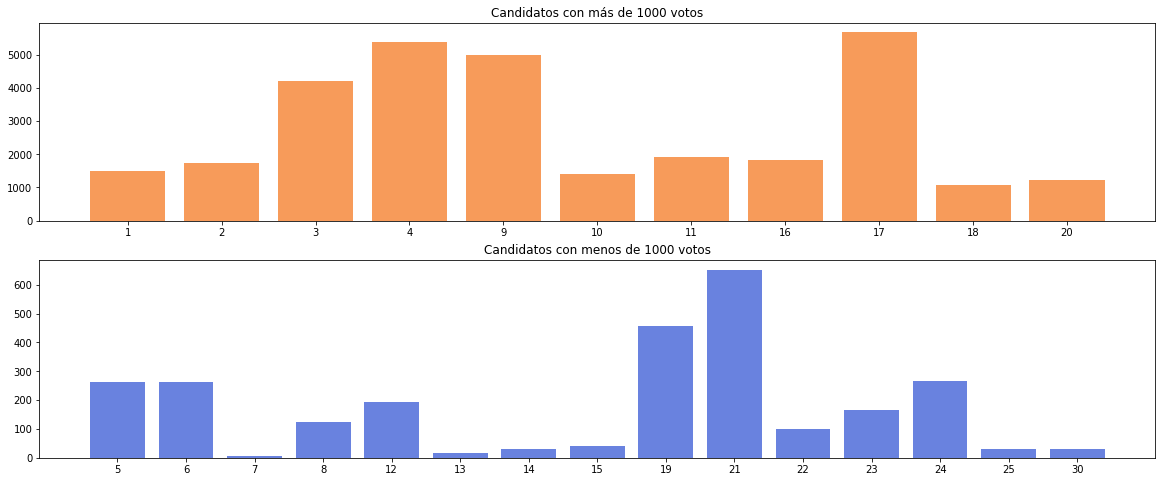

Partidos con más de 1000 votos: 
0 - Frente Amplio
1 - La Alternativa
2 - Partido Colorado
5 - Partido de la Gente
6 - Partido Nacional

Partidos con menos de 1000 votos: 
3 - Partido Ecologista Radical Intransigente
4 - Partido Digital
7 - Partido de los Trabajadores
8 - Partido Verde Animalista
9 - Unidad Popular
10 - Partido de Todos



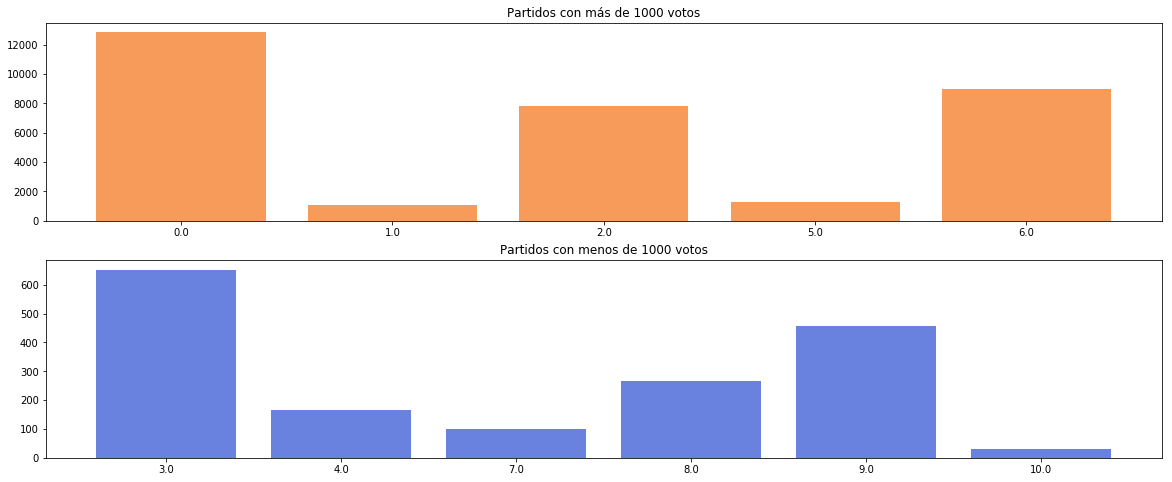

In [4]:
# Script que grafica métricas del corpus

import os
import sys
import evaluation.evaluator as evaluator
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import utils.gui as gui
import processing.reader as reader
import plotting.corpusPlotting as corpusPlotting
import plotting.pcaPlotting as pcaPlotting
from utils.const import DATA_ENCUESTAS
%matplotlib inline 

# Leer dataset de respuestas a encuesta separando entre candidatos con más y menos de 1000 votos
datasetCandidatosMasMil = reader.readDatasetCandidatosMasMil('../' + DATA_ENCUESTAS, options={'from_notebook': True})
datasetCandidatosMenosMil = reader.readDatasetCandidatosMenosMil('../' + DATA_ENCUESTAS, options={'from_notebook': True})

# dataset con partidos con mas de mil votantes
datasetPartiesMasMil = reader.readDatasetPartiesMasMil('../' + DATA_ENCUESTAS, options={'from_notebook': True})
datasetPartiesMenosMil = reader.readDatasetPartiesMenosMil('../' + DATA_ENCUESTAS, options={'from_notebook': True})

# levantar datos de partidos y candidatos de los JSON.
candidatesJSON = reader.readCandidates(options = {'from_notebook': True})
partiesJSON = reader.readParties(options = {'from_notebook': True})

# Graficar distribución de votantes según candidato y partido
corpusPlotting.plotCorpus(datasetCandidatosMasMil, datasetCandidatosMenosMil, datasetPartiesMasMil, datasetPartiesMenosMil, candidatesJSON, partiesJSON)


## 3. Separación del corpus 80/20 (parte b)
***
En esta seccion separaremos el corpus de datos en un corpus de entrenamiento y corpus de evaluacion para los conjuntos filtrados con mas de mil votantes por candidatos y mas de mil votantes por partidos.

### 3.1. Métodos de evaluación
***
En este laboratorio se usaran dos métodos de evaluación. Primero el método de validación normal, partiendo el conjunto de datos en 2, donde por un lado nos queda un conjunto de datos para entrenar y por otro un subconjunto para testear el algoritmo. Se realiza una partición 80/20, entrenamiento y test, respectivamente.

Para implementar la validación normal, sci-kit learn provee de una función para separar el conjunto de datos en entrenamiento y test. La función es train_test_split y se le pasan por parámetro el conjunto de entrenamiento a separar y opcionalmente algunos parámetros que si no son ingresados, se toma sus valores por defecto. Entre ellos tenemos **test_size** siendo un valor entre 0 y 1 el cual determina la proporción del conjunto de datos a usar como test. Otro parámetro es **train_size** que si no se lo ingresa, se define como **1 - test_size**. Por defecto **test_size** vale 0.25. Otro parámetro útil es **shuffle**, el cual antes de separar desordena el conjunto de datos aleatoriamente (por defecto es True).

El otro método de evaluación es la validación cruzada. Se denomina como **validación cruzada** a la partición del conjunto $D$ en $k$ particiones $T_i$ y $E_i : i \in [1..k]$,  utilizando una proporción de $\frac{k-1}{k}$ y $\frac{1}{k}$ ejemplos para $T_i$ y $E_i$ respectivamente.

Esta estrategia es más robusta que la **validación normal** anteriormente mencionada, sin embargo tiene el problema de tener un mayor orden computacional, dado que tiene que correr $k$ entrenamientos en lugar de uno.

En este caso, sci-kit learn provee de una función para implementar la validacion cruzada (**cross_validate**). A la función se le pasa el modelo (en nuestro caso la LogisticRegression), el conjunto de datos sin contener el valor objetivo (la clase de cada ejemplo de entrenamiento), la clasificación de cada ejemplo del conjunto de entrenamiento y se configura el parámetro **cv** para indicar el valor del **k** para realizar las particiones.

En la experimentación se decidió probar con $k=5$ y #k=10#.

### 3.1. Separación del corpus
***
Ahora vamos a aplicar la función de scki-kit learn mencionada en la subsección anterior.


In [2]:
from sklearn.model_selection import train_test_split

# Separamos por data, candidates, parties (esctructura devuelta por readDatasetCandidatosMasMil y las demas readDataset)

datasetCMasMil, candidatesCMasMil, partiesCMasMil = datasetCandidatosMasMil
datasetPMasMil, candidatesPMasMil, partiesPMasMil = datasetPartiesMasMil


dataset_candidates, testset_candidates, candidates, testset_candidates_results = train_test_split(datasetCMasMil, candidatesCMasMil, test_size=0.2)
dataset_parties, testset_parties, parties, testset_parties_results = train_test_split(datasetPMasMil, partiesPMasMil, test_size=0.2)


## 4. Clasificador para candidatos y para partidos (parte c)
***
En esta sección se va a presentar el modelo implementado, se van a variar distintos parámetros del modelo hasta encontrar el modelo que nos devuelva los mejores resultados según la accuracy.

### 4.1. Modelo
***
La regresión logística es un método de clasificación que utiliza la misma especificación que la regresión lineal, pero en este caso la clasificación toma valores discretos.

Se utiliza la función sigmoide a su salida ya que tiende a $0$ cuando $z$ tiende a $-\infty$, y tiende a $1$ cuando $z$ tiende a $+\infty$ y es una función diferenciable.

La función sigmoide o tambien conocida como función logística se define:

$$ h_\theta(x) = g(\theta^Tx) = \frac{1}{1+e^{-\theta^Tx}}\text{ , donde } g(z)= \frac{1}{1+e^{-z}}$$

Dado que utilizamos esta función, la función de costo usada en regresion lineal no nos sirve y debemos definir una nueva función de costo para regresion logistica. Como se vio en el teorico la función de costo en su versión vectorial es la siguiente:

$$
J(\theta) = -\frac{1}{m}\sum_{i=1}^m \left [ y^T log (h_\theta(x)) + (1 - y^T ) log (1 - h_\theta(x))\right ] 
$$

Al igual que en regresion lineal se utiliza descenso por gradiente para ajustar los pesos. La regla en su versión vectorial es la siguiente:

$$ \theta := \theta - \alpha \frac{1}{m} X^T (g(X\theta) - y)  $$

Hasta este punto, el clasificador de regresión logística funciona de manera binaria haciendo clasificaciónes verdadero o falso. Se busca extender esta idea para lograr una clasificación multiclase. Se divide el problema en $(n+1)$ problemas de clasificación binaria donde se busca el valor de $h_\theta^{(i)}(x)$ mas grande:

$$
h_\theta^{(i)} = P(y=i\ \mid x;\theta) \\
\text{predecir  para } x = \max_i (h_\theta^{(i)})
$$

Para evitar sobreajuste se aplica una regularizacion a la función de costo. Esto agrega cierta generalidad al momento de clasificar ejemplos nuevos sin quedar totalmente ajustado a los ejemplos de entrenamiento. La función de costo queda como sigue:


$$J(\theta) = - \frac{1}{m} \sum_{i=1}^m \left[ y^{(i)}\ \log (h_\theta (x^{(i)})) + (1 - y^{(i)})\ \log (1 - h_\theta(x^{(i)}))\right] + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2$$

Esta forma de regresión se conoce también como $Ridge$ ya que utiliza el cuadrado del peso para regularizar.

La nueva regla de descenso por gradiente para cada peso:

$$ \theta_0 := \theta_0 - \alpha \frac{1}{m}\sum_{i=1}^{m}  (h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_0 $$

$$\theta_j := \theta_j - \alpha \left [ \left ( \frac{1}{m}\sum_{i=1}^{m}  (h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j \right 
) + \frac{\lambda}{m}\theta_j  \right ] $$


### 4.3. Algoritmo
***
En esta subsección se presenta como se implementó la regresión logística sobre el conjunto de datos.

#### 4.3.1. Algoritmo de entrenamiento
***
Como se vio en el teórico, la regresión logística se entrena haciendo un ajuste a sus pesos por medio de un descenso por gradiente dada la función de costo seleccionada. Se utilizó la función LogisticRegression de scikit learn para implementar la regresión.

La librería provee de distintos tipos de solver para aplicar la regresión. Las opciones disponibles son newton-cg, lbfgs,
liblinear, sag y saga. El solver liblinear es usado por defecto si no se especifica y se basa en la librería liblinear en C++. Tiene buenos resultados en conjuntos de datos con muchas dimensiones. El solver newton-cg y lbfgs son buenos cuando la funciones a aproximar son cuadráticas dada la naturaleza de sus implementaciones. El solver sag y saga usan descenso por gradiente estocástico y entre ellos se diferencian en que saga también acepta otro tipo de penalty como veremos más adelante en esta sección.

El algoritmo itera hasta la convergencia. Si la convergencia no se obtiene se puede determinar una cantidad máxima de iteraciones para obtener un resultado óptimo.

#### 4.3.2. Parámetros - Normalización
***
Dado que los atributos del corpus (o sea las respuestas a las preguntas) toman todos valores de 1 a 5, no es necesario hacer una normalización de los datos de entrada.

#### 4.3.3. Parámetros - Regularización y penalización
***
Como vimos en el teórico, la regularización es utilizada para evitar que la regresión se sobreajuste a los datos de entrenamiento. Si ocurre un sobreajuste se pierde la capacidad de generalización del algoritmo. La técnica consiste en agregar un componente de penalización a la función de costo.

La implementación de regresión logistica de scikit-learn nos provee del parametro **penalty** el cual se usa para especificar la norma utilizada en la penalización. Esta norma es luego utilizada en la regularización.

Existen 4 opciones de penalización. Se tiene 'l2', 'l1', 'elasticnet' y 'None'. El tipo 'l2' se conoce como penalizacion de Ridge. El tipo 'l1' se conoce como penalizacion de Lasso. El tipo 'elasticnet' es una combinacion de 'l1' y 'l2'.

link referencia: http://enhancedatascience.com/2017/07/04/machine-learning-explained-regularization/

Los solver newton-cg, sag y lbfgs solo soportan el penalizador 'l2'. El penalizador 'elasticnet' solo es soportado por el solver 'saga'. Si se selecciona 'None' no se aplica regularizacion. El solver liblinear no soporta la opcion 'None'.

Luego de elegido el penalizador, se debe determinar un valor para el coeficiente de regularizacion. Si se toma un valor muy grande se produce un underfitting y si el valor es muy pequeno se va a sobreajustar sobre los ejemplos de entrenamiento. La libreria provee del parametro **C**. **C** es el inverso de la fuerza de regularizacion, por lo tanto debe ser un valor positivo distinto de 0. Por defecto el valor de **C** es 1.0.

#### 4.3.4. Parámetros - Enfoque multiclase y Clasificación
***
La implementacion del algoritmo da la opcion a seleccion si realizamos una clasificacion multiclase o binaria. Para esto se provee del parametro **multi_class**. Los valores posibles son ovr, multinomial y auto. En nuestro caso utilizamos ovr que significa one versus rest. Este parametro crea internamente una regresion logistica binaria por cada clase y luego como se detallo anteriormente, se elige al de mayor valor.

#### 4.3.5. Parámetros - Convergencia e iteraciones
***
Como se mencionó anteriormente, si no se llega a una convergencia, se debe detener el algoritmo en algún momento, ya sea utilizando una tolerancia (usada por defecto en 1e-04 por la implementación de la librería) o definiendo un máximo de iteraciones. En nuestro caso decidimos limitar la cantidad de iteraciones con el parámetro **max_iter**.

### 4.4 Métricas
***
Se utilizaron múltiples métricas para determinar la "calidad" o "eficacia" de los clasificadores entrenados. A continuación, una breve descripción de las mismas:

#### 4.4.1 Accuracy
***
La **accuracy** o **exactitud** hace referencia a la cantidad de aciertos que el clasificador tuvo en relación al total de clasificaciones que realizó durante la evaluación. Para definir **accuracy**, se utilizan las siguientes nociones:
- Sea $D$ el conjunto de datos, $C_D$ el conjunto de posibles clasificaciones en $D$ y $|C_D| = n$
- Sea $t_i : i \in [1..n]$ la cantidad de clasificaciones para la clase $i$ que fueron correctas
- Sea $f_i : i \in [1..n]$ la cantidad de clasificaciones para la clase $i$ que fueron incorrectas

$$ accuracy = \frac{\sum_{i=1}^{n} t_i}{\sum_{i=1}^{n} t_i + f_i}$$

Se observa que **accuracy** no es una muy buena medida de performance, ya que depende mucho del conjunto de datos que se evalúe, pudiendo dar buenos resultados a un clasificador malo. Teniendo esto en cuenta, se utilizó esta métrica solo para tener una noción general del desempeño de un clasificador, dandole más peso a las métricas definidas a continuación.

#### 4.4.2 Matriz de Confusión
***
La **matriz de confusión** es una matriz que permite almacenar todas las clasificaciones realizadas en una evaluación, basándose en cada resultado y su respectivo valor original. La estructura de la matriz es la siguiente:

- Sea $D =$ Conjunto de datos
- Sea $C_D =$ Conjunto de clasificaciones para $d \in D$ 
- Sea $|C_D| = n$ cantidad de posibles clasificaciones en $C_D$
- Sea $M$ la matriz de confusión para una evaluación definida como:

$$M = \begin{bmatrix}
    x_{11} & x_{12} & \dots  & x_{1n} \\
    x_{21} & x_{22} & \dots  & x_{2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    x_{n1} & x_{n2} & \dots  & x_{nn}
\end{bmatrix}$$

- Entonces $x_{ij} \in M : i,j \in [1..n]$ representa la cantidad de clasificaciones que originalmente eran **clase $i$** y que fueron clasificadas en la evaluación como **clase $j$**.

De esta forma, en una matriz cuadrada de dimensión $n$, se pueden centralizar todas las clasificaciones realizadas y su relación con respecto a cada clase.

En sí misma, la matriz de confusión no representa una métrica sino una herramienta para calcular otras métricas, las cuales serán detalladas a continuación. De todas formas, una mirada superficial a una matriz de confusión de tamaño razonable puede aportar información general sobre el desempeño del clasificador, (esto es detallado en la siguiente subsección).

#### 4.4.3 Precision, Recall, F-measure
***
Usamos tres medidas que, si bien siguen una fórmula similar a la de **accuracy**, son mucho menos sensibles al ruido en el conjunto de datos $D$, ya que operan **por clase**. Antes de detallar cada una, se repasan ciertas nociones básicas utilizadas en la definición de cada métrica.

Retomando el punto anterior, la matriz de confusión permite calcular para cada clase $c_i$, cuatro valores indispensables:
- Los **verdaderos positivos** en la clase $c_i$ (denotados como $t_i$), son aquellos ejemplos que originalmente son clase $c_i$ y fueron clasificados correctamente en la evaluación como clase $c_i$. Para calcularlos utilizando la matriz de confusión, simplemente hay que tomar la celda $M(i,i)$ para la clase $c_i$.

$$ t_i = M(i,i) $$

- Los **falsos positivos** en la clase $c_i$ (denotados como $f_i$), son aquellos ejemplos que originalmente son clase $c_j : j \neq i$ y fueron clasificados incorrectamente en la evaluación como clase $c_i$. Para calcularlos utilizando la matriz de confusión, simplemente hay que tomar la fila $M_{(i,)}$ para la clase $c_i$, y sumar todos sus valores (excepto la celda $M(i,i)$, que corresponde a los verdaderos positivos).

$$ f_i = \sum_{j=1, j \neq i}^{n} M(i,j) $$

- Los **verdaderos negativos** en la clase $c_i$ (denotados como $\bar{t_i}$), son aquellos ejemplos que originalmente no son clase $c_i$ y fueron clasificados en la evaluación como clase $c_j : j \neq i$. Cabe destacar que la clasificación como $c_j$ puede ser correcta o no, lo importante es que sea consistente en relación a $c_i$. Para calcularlos utilizando la matriz de confusión, simplemente hay que tomar la matriz adjunta a los verdaderos positivos de $c_i$ y sumar todas sus entradas. Dicha matriz se define como $M_{ii}$ y contiene todas las entradas de $M$ excepto la fila $i$ y la columna $i$.

$$ \bar{t_i} = \sum_{j=1}^{n-1} \sum_{k=1}^{n-1} M_{ii}(j,k) $$

- Los **falsos negativos** en la clase $c_i$ (denotados como $\bar{f_i}$), son aquellos ejemplos que originalmente son clase $c_i$ y fueron clasificados incorrectamente en la evaluación como clase $c_j : j \neq i$. Para calcularlos utilizando la matriz de confusión, simplemente hay que tomar la columna $M_{(,i)}$ para la clase $c_i$, y sumar todos sus valores (excepto la celda $M(i,i)$, que corresponde a los verdaderos positivos).

$$ \bar{f_i} = \sum_{j=1, j \neq i}^{n} M(j,i) $$

Teniendo en cuenta dichas definiciones, se pasa a definir las métricas utilizadas:
- **Precision**
> - La **precision** o precisión de una **clase $c_i$** hace referencia a la cantidad de clasificaciones correctas para dicha clase, en relación a la cantidad de clasificaciones totales (correctas e incorrectas) para dicha clase.
> - La precision permite determinar "que tan bien se clasifica una clase". En otras palabras, que tan poco se equivoca el clasificador en marcar un ejemplo como cierta clase.
> - Oscila entre 0 y 1, siendo mejor cuanto **mayor** es.
> - Se calcula como:
> $$ precision(c_i) = \frac{t_i}{t_i + f_i}$$

- **Recall**
> - La **recall** o recuperación de una **clase $c_i$** hace referencia a la cantidad de clasificaciones correctas para dicha clase, en relación a la cantidad de clasificaciones originales para dicha clase.
> - La recall permite determinar "que tan bien se clasifican elementos de otras clases respecto a una clase". En otras palabras, que tan poco se equivoca el clasificador en marcar un ejemplo de otras clases como cierta clase.
> - Oscila entre 0 y 1, siendo mejor cuanto **mayor** es.
> - Se calcula como:
> $$ recall(c_i) = \frac{t_i}{t_i + \bar{f_i}}$$

- **F-measure**
> - La **F-measure** o medida-F de una **clase $c_i$** es una medida que relaciona **precision** y **recall**, oficiando de alguna forma como un representante de cierta clase.
> - La F-measure permite determinar "que tan bien se clasifica una clase y que tan poco se falla a la vez". En otras palabras, es una relación proporcional entre la precision y la recall y por tanto es una buena métrica para determinar el desempeño del clasificador respecto a una clase.
> - Oscila entre 0 y 1, siendo mejor cuanto **mayor** es.
> - Se calcula como:
> $$ Fmeasure(c_i) = \frac{2 precision(c_i) recall(c_i)}{precision(c_i) + recall(c_i)}$$

Si bien estas medidas ofrecen información más enriquecedora en comparación a las anteriormente mencionadas, cuentan con el "defecto" de aplicar por clase y no dar una medida general del clasificador. Para conjuntos $D$ con pocas clasificaciones en $C_D$ esto no es un gran problema, pero complica la comparación al aumentar la cantidad de clases.

### 4.5 Resumen
***
En resumen, para nuestra implementación de regresión logística usando la librería sci-kit learn vamos a variar los siguientes parámetros del modelo:

- **solver**: Los valores a variar son newton-cg, lbfgs,liblinear, sag y saga.
- **penalty**: Los valores a variar son l2, l1 y None. 
- **max_iter**: Este valor por defecto probamos con 1000 iteraciones.
- **C**: Este valor es el inverso del regularization strength. Como se mencionó debe ser un valor positivo mayor que cero.

Para el parámetro **multi_class** se fija el valor 'ovr' (one-versus-rest) dado que buscamos una clasificación multiclase compuesta por varios clasificadores binarios donde cada uno clasifica su clase y luego se decide según el que devuelva un valor máximo entre ellos.


### 4.6 Búsqueda de mejores modelos
***
Se implementó un función que varía los parámetros señalados en la subsección **4.5**. 

#### 4.6.1 validación cruzada k = 5
***
A continuación se busca el modelo con validación cruzada en k = 5.

In [ ]:
# Evaluar todas las configuraciones paramétricas posibles y ordenarlas según accuracy para k = 5
candidate_classifiers, party_classifiers = evaluator.getBestModel(dataset_candidates, candidates, candidates, dataset_parties, parties, parties, 5)

# Mostrar el mejor clasificador según candidatos y según partidos
candidates_best_model5, parties_best_model5 = gui.printBestClassifiers(candidate_classifiers, party_classifiers)

#### 4.6.2 validación cruzada k = 10
***
A continuación se busca el modelo con validación cruzada en k = 10.

In [ ]:
# Evaluar todas las configuraciones paramétricas posibles y ordenarlas según accuracy para k = 10
candidate_classifiers10, party_classifiers10 = evaluator.getBestModel(dataset_candidates, candidates, candidates, dataset_parties, parties, parties, 10)

# Mostrar el mejor clasificador según candidatos y según partidos
candidates_best_model10, parties_best_model10 = gui.printBestClassifiers(candidate_classifiers, party_classifiers)

-> Accuracy (Candidatos): 0.5936743585605938
-> Accuracy (Partidos): 0.9215978069316624
-> Accuracy (Candidatos): 0.6147329352912699
-> Accuracy (Partidos): 0.9282944977481887
-> Accuracy (Candidatos): 0.6280861707277715
-> Accuracy (Partidos): 0.9358527511259056
-> Accuracy (Candidatos): 0.6301839599806358
-> Accuracy (Partidos): 0.9377716859212845
-> Accuracy (Candidatos): 0.5936743585605938
-> Accuracy (Partidos): 0.9215978069316624
-> Accuracy (Candidatos): 0.6147329352912699
-> Accuracy (Partidos): 0.9282944977481887
-> Accuracy (Candidatos): 0.6280861707277715
-> Accuracy (Partidos): 0.9358527511259056
-> Accuracy (Candidatos): 0.6301839599806358
-> Accuracy (Partidos): 0.9377716859212845
-> Accuracy (Candidatos): 0.5936743585605938
-> Accuracy (Partidos): 0.9215978069316624
-> Accuracy (Candidatos): 0.6147329352912699
-> Accuracy (Partidos): 0.9282944977481887
-> Accuracy (Candidatos): 0.6280861707277715
-> Accuracy (Partidos): 0.9358527511259056
-> Accuracy (Candidatos): 0.6301

/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

-> Accuracy (Candidatos): 0.6271583024043892
-> Accuracy (Partidos): 0.9295868415899745


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

-> Accuracy (Candidatos): 0.6301436178796191
-> Accuracy (Partidos): 0.9373409046406892


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

-> Accuracy (Candidatos): 0.6303453283847023
-> Accuracy (Partidos): 0.9380458194634815


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


-> Accuracy (Candidatos): 0.6304260125867355
-> Accuracy (Partidos): 0.9381633052672802
-> Accuracy (Candidatos): 0.6271583024043892
-> Accuracy (Partidos): 0.929547679655375
-> Accuracy (Candidatos): 0.6301436178796191
-> Accuracy (Partidos): 0.9373409046406892
-> Accuracy (Candidatos): 0.6303453283847023
-> Accuracy (Partidos): 0.9380458194634815
-> Accuracy (Candidatos): 0.6304260125867355
-> Accuracy (Partidos): 0.9381633052672802
-> Accuracy (Candidatos): 0.6271583024043892
-> Accuracy (Partidos): 0.929547679655375
-> Accuracy (Candidatos): 0.6301436178796191
-> Accuracy (Partidos): 0.9373409046406892
-> Accuracy (Candidatos): 0.6303453283847023
-> Accuracy (Partidos): 0.9380458194634815
-> Accuracy (Candidatos): 0.6304260125867355
-> Accuracy (Partidos): 0.9381633052672802


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.6070679360981119
-> Accuracy (Partidos): 0.9239866849422361


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.6089640148458931
-> Accuracy (Partidos): 0.9280203642059918


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.6094481200580927
-> Accuracy (Partidos): 0.9287644409633836


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.6094884621591092
-> Accuracy (Partidos): 0.9287644409633836


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.625907697272874
-> Accuracy (Partidos): 0.9288427648325828


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.6279651444247216
-> Accuracy (Partidos): 0.9365185040140983


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.6290140390511538
-> Accuracy (Partidos): 0.9371059330330919


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.6290140390511538
-> Accuracy (Partidos): 0.9372625807714902
-> Accuracy (Candidatos): 0.6263514603840568
-> Accuracy (Partidos): 0.9288427648325828
-> Accuracy (Candidatos): 0.6286106180409876
-> Accuracy (Partidos): 0.9365968278832975
-> Accuracy (Candidatos): 0.6296595126674197
-> Accuracy (Partidos): 0.9376150381828863
-> Accuracy (Candidatos): 0.6296998547684364
-> Accuracy (Partidos): 0.9376933620520854


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.5998467000161368
-> Accuracy (Partidos): 0.9228509888388486


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.6015410682588349
-> Accuracy (Partidos): 0.9266105345604073


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.6019848313700178
-> Accuracy (Partidos): 0.9271588016448012


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.6019848313700178
-> Accuracy (Partidos): 0.9271588016448012


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

-> Accuracy (Candidatos): 0.6228416975956108
-> Accuracy (Partidos): 0.9286077932249853


/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/leandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

#### 4.6.3 Elección de modelos para candidatos y para partidos
***
Luego de haber hallado los cuatro mejores modelos para candidatos y partidos con k = 5 y k = 10, seleccionamos los mejores dos representantes para las pruebas de ahora en adelante.

In [ ]:
# modelos representantes.
candidates_model = None
parties_model = None

## 5. Selección de n componentes principales (parte d)
***
En esta sección vamos a fijar el modelo que tuvo mejores resultados y probar por validación cruzada sobre el conjunto de datos variando la cantidad de componentes principales (usando PCA).

### 5.1 Reducción de dimensionalidad
***
En modo experimental, se puede realizar una reducción de dimensiones utilizando PCA. Se puede comprobar si clasificando utilizando determinada cantidad de componentes principales luego de aplicar PCA, los resultados siguen similares descartando aquellas componentes de menor varianza.
Para implementar la reducción de dimensionalidad utilizamos PCA de la librería sci-kit learn.

El último parámetro del método **getBestModel** es un booleano que si se pasa en True, se realiza la prueba variando **n** de 1 a 25.

### 5.2 Reducción de dimensionalidad usando k = 5

In [ ]:
# Evaluar todas las configuraciones paramétricas posibles y ordenarlas según accuracy para k = 5.
# Se aplica PCA buscando mejores resultados.
candidate_classifiers, party_classifiers = evaluator.getBestModel(dataset_candidates, candidates, candidates, dataset_parties, parties, parties, 5, True)

# Mostrar el mejor clasificador según candidatos y según partidos
candidates_best_modelPCA5, parties_best_modelPCA5 = gui.printBestClassifiers(candidate_classifiers, party_classifiers)

### 5.3 Reducción de dimensionalidad usando k = 10

In [ ]:
# Evaluar todas las configuraciones paramétricas posibles y ordenarlas según accuracy para k = 10.
# Se aplica PCA buscando mejores resultados.
candidate_classifiers, party_classifiers = evaluator.getBestModel(dataset_candidates, candidates, candidates, dataset_parties, parties, parties, 10, True)

# Mostrar el mejor clasificador según candidatos y según partidos
candidates_best_modelPCA5, parties_best_modelPCA5 = gui.printBestClassifiers(candidate_classifiers, party_classifiers)

### 5.4 Elección de mejores modelos reducidos con PCA
***
A continuación se van a guardar los mejores dos modelos obtenidos luego de reducir n componentes probando con validación cruzada sobre el corpus de entrenamiento.

In [ ]:
# modelos reducidos representantes.
candidates_model_pca = None
parties_model_pca = None

### 5.5 Ratio de varianza explicada de PCA de cada modelo
***
Aquí se graficara el explained variance ratio para tener una visión cuantitativa de cuanto porcentaje varianza aporta cada componente principal. Se realiza para el dataset con candidatos con más de mil votantes y para el dataset con partidos con más de mil votantes.

#### 5.5.1 Ratio de varianza explicada para dataset de candidatos
***


In [ ]:
# Grafica explained variance ratio para dataset de candidatos.
pcaPlotting.plotPCA(datasetCandidatosMasMil)

#### 5.5.2 Ratio de varianza explicada para dataset de partidos
***


In [ ]:
# Grafica explained variance ratio para dataset de partidos.
pcaPlotting.plotPCA(datasetPartiesMasMil)

## 6. Reporte de metricas por modelos (parte e)
***
En esta sección se van a realizar los reportes de las métricas accuracy, precision, re-call y f-measure para cada modelo obtenido en las parte c (modelos de regresión logística completos) y parte **d** (modelos de regresión logística reducidos a n componentes principales).
Se van a clasificar los ejemplos correspondientes al corpus de evaluación separado en la sección 3.

In [ ]:
# Se importan las funciones de la libreria a utilizar
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 6.1 Reporte de modelo regresión logística de candidatos sin reducir PCA
***


In [ ]:
# Obtener la clasificacion del corpus de evaluacion
candidates_evaluated = candidates_model.predict(testset_candidates)

# Obtener accuracy
accuracy_candidates = accuracy_score(testset_candidates_results, candidates_evaluated)

# Obtener reporte
report_candidates = classification_report(testset_candidates_results, candidates_evaluated) 

# Obtener matriz de confusion
confusion_matrix_candidates = confusion_matrix(testset_candidates_results, candidates_evaluated)

# Imprimir resultados
print("-> Accuracy: ", accuracy_candidates)
print()

print(report_candidates)
print()

print(confusion_matrix_candidates)
print()


Comentarios...

### 6.2 Reporte de modelo regresión logística de partidos sin reducir PCA
***


In [ ]:
# Obtener la clasificacion del corpus de evaluacion
parties_evaluated = parties_model.predict(testset_parties)

# Obtener accuracy
accuracy_parties = accuracy_score(testset_parties_results, parties_evaluated)

# Obtener reporte
report_parties = classification_report(testset_parties_results, parties_evaluated) 

# Obtener matriz de confusion
confusion_matrix_parties = confusion_matrix(testset_parties_results, parties_evaluated)

# Imprimir resultados
print("-> Accuracy: ", accuracy_parties)
print()

print(report_parties)
print()

print(confusion_matrix_parties)
print()

Comentarios...

### 6.3 Reporte de modelo regresión logística de candidatos con reducción PCA
***

In [ ]:
# Obtener la clasificacion del corpus de evaluacion
candidates_evaluated_pca = candidates_model_pca.predict(testset_candidates)

# Obtener accuracy
accuracy_candidates_pca = accuracy_score(testset_candidates_results, candidates_evaluated_pca)

# Obtener reporte
report_candidates_pca = classification_report(testset_candidates_results, candidates_evaluated_pca) 

# Obtener matriz de confusion
confusion_matrix_candidates_pca = confusion_matrix(testset_candidates_results, candidates_evaluated_pca)

# Imprimir resultados
print("-> Accuracy: ", accuracy_candidates_pca)
print()

print(report_candidates_pca)
print()

print(confusion_matrix_candidates_pca)
print()

Comentarios...

### 6.4 Reporte de modelo regresión logística de partidos con reducción PCA
***

In [ ]:
# Obtener la clasificacion del corpus de evaluacion
parties_evaluated_pca = parties_model_pca.predict(testset_parties)

# Obtener accuracy
accuracy_parties_pca = accuracy_score(testset_parties_results, parties_evaluated_pca)

# Obtener reporte
report_parties_pca = classification_report(testset_parties_results, parties_evaluated_pca) 

# Obtener matriz de confusion
confusion_matrix_parties_pca = confusion_matrix(testset_parties_results, parties_evaluated_pca)

# Imprimir resultados
print("-> Accuracy: ", accuracy_parties_pca)
print()

print(report_parties_pca)
print()

print(confusion_matrix_parties_pca)
print()

Comentarios...

## 7. Modelo de partidos a partir de modelo de candidatos (parte f)
***
En esta sección se va a tomar el modelo para clasificar partidos, se va a clasificar el corpus de evaluación generado en la sección 3, se va a hallar la acuraccy y se va a comparar con la accuracy devuelta por el modelo de partidos anteriormente implementado.
Luego para el nuevo modelo armado, se busca reducir componentes mediante PCA y seleccionar el n conveniente.

### 7.1 Implementación de modelo de partidos a partir de modelo de candidatos
***


In [ ]:
# tomar modelo de candidatos elegido..
model_candidate_partF = None

# definir con la mente mas fresca..

# modificar funcion de get best model para que se avise que haga el mapeo de candidatos a partidos internamente
# usando modelo de candidatos.

# Medir la accuracy con respecto a los resultados verdaderos del corpus de evaluacion para los partidos


# Comparar con la accuracy que daba el modelo de partidos


Comentarios sobre la comparacion.

### 7.2 Evaluación de reducción a PCA usando modelo de partidos a partir de modelo de candidatos
***


In [ ]:
# modificar funcion de get best model para que se avise que haga el mapeo de candidatos a partidos internamente
# usando modelo de candidatos.

# variar n y buscar mas conveniente.

Comentarios sobre comparacion de accuracy luego de la reduccion PCA.

## 8. Concluciónes
***
Ver si poner o no.

## 9. Referencias
***
Si las hay
[1] **titulo** - *author* - url

[2] **titulo** - *author* - url

[3] **titulo** - *author* - url 